# § WikiMon

**WikiMon** is a _monitor_ to track the stream of _change-log_ events
by users to **Wikipedia**'s English corpus.
On request,
it profiles the distribution of a tracked user's change events.

|                   |                          |
|------------------:|:-------------------------|
| template authors: | Parke Godfrey & Aijun An|
|             date: | 6 March 2025             |

---
### ¶ Project Overview

You are to build an application that reads a "stream" of change events to **Wikipedia**
as provided by the **Wikimedia** platform.
We track when each _top user_ (provided) makes changes,
to be able to _profile_ when the user was active.

For profiling _top users_,
we build a light-weight _synopsis_
—
light-weight both in computation and in memory footprint
—
per user via the DGIM algorithm.

The project consists of _three parts_:

1. _Ingesting the stream_, building the synopses.
  * Implement the DGIM algorithm so you can build synopses
   incrementally while processing stream events.
  * Implement functions for later tasks to query the synopses.
2. _Profiling users_ to show their distributions of changes.  
  Here, you are to investigate the strengths and weaknesses of DGIM,
  to understand better in which ways it is effective.
  1. _produce hourly histograms_
    * Approximate a user's count of change events hourly
     from the start of the stream to the “end” (the “current” time)
     via the DGIM synoposis for the user.
    * Produce the same histogram but with respect to the _ground truth_.
  2. _plot absolute error of predicted histograms_
    * Given an hourly histogram as produced by a synopsis
     for a user, plot its absolute error against the ground truth.
  3. _plot relative error of synopses_
    * Given a synopsis,
     plot its relative error against the ground truth,
     to verify DGIM's approximation bounds.
3. _Reporting results_.
  * Answer the specific questions asked
   regarding the synopsis techniques.
  * For brevity, try to keep your answer to each question
   fewer than 150 words.

---
### ¶ The Platform

Host yout notebook and runtime on **Google Colab** as with the previous project.
However,
you do not need to use **pyspark** as in the last project,
as we do not need to run distributed in this case.
Just “**Python**” suffices.

Of course,
beyond this project, if we wanted to _scale out_ the _monitor_ to track
many, many users, we easily could adapt this for **pyspark**.
If we were to adapt this for monitoring the live stream
**Wikimedia**'s _recentchange_,
we would further use, say, **Kafka** for handling synchronization, etc.

---
### ¶ Instructions

For your _final notebook_ that you turn it,
you should perform a complete run of the notebook.
* _final notebook_
  * Your notebook will show in the _ouput_ cells
   the results of the last run you performed.
  * Choose your favourite, or most interesting, _three_ tracked users
   to demonstrate the _hourly histograms_
   and
   _absolute-_
   and
   _relative error plots_
   from your synopses and from the ground truth.
   The corresponding output cells should show
   those histograms and plots.
* _notebook & coding style_
  * Follow proper Jupyter notebook style conventions.
    * Feel free to add cells as needed.
    * _Do not_, however, change the titles or order of the cells
     from the initial template notebook.
  * Follow proper Python coding conventions.
    * Do comment your code appropriately.
    * Have meaningful output produced in the _output cells_
     that makes it easy to see what the code does.
    * Keep lines of code _within_ line-width 80!
      * This is actually a Python style requirement,
        although Python does not enforce it.
      * This is important for us because you will also be
       turning in a **pdf** printout of your notebook.
       Longer code lines would be cut off in the **pdf**.
* _report_
  * Fill in the last _text_ cell, Section **Report**,
   with the requested information.

Note that you are to implement the DGIM synopsis code yourself,
and _not_ use any _imports_ / _libraries_ that are specifically
for the method.
You may **not** _import_ anything beyond what is included in this template.

---
### ¶ The Stream & the Event Data

**The “Fake” Stream**

Instead of pulling the associated live stream from **Wikimedia**,
we _fake_ this by reading a file of events that have already been collected.
This is so we do not pound **wikimedia**'s resources with class projects;
it is not intended to support that.
But we could easily extend our setup to work off the live stream.

We collected the `recentchange` events from **Wikimedia**
from _Wed Feb 12 2025 02:14:32 GMT+0000_ (`1739326472`)
through _Thu Feb 20 2025 00:36:05 GMT+0000_ (`1740011765`),
so nearly eight days of data.
This consists of 1,117,049 events by 112,151 distinct users.

**The Real Stream**

**Wikimedia** provides tools to monitor **Wikipedia**.
(See [_Event Platform/EventStreams HTTP Service - Wikitech_][WikiTech SSE]
for initial documentation of the streams they host.)
Their _recentchange_ stream streams in realtime _events_ of changes
being made to **Wikipedia** assets.

One can “open” the URL [`stream.wikimedia.org/v2/stream/recentchange`][recentchange]
in a web browser to start receiving the stream.
(Just please close that _page_ shortly if you do,
not to be swamping **Wikimedia**'s resources!)
This is a stream of _events_, an event being a _change_
to some **Wikipedia** _article_ a “user” made.
Each event is delivered as a **JSON** document.
You can explore what information (key-value pairs) is provided.

For the fake-stream file,
we projected the following keys with their values per event:

* `user`
* `timestamp`
* `title`
* `title_url`
* `parsedcomment`
* _delta_

The _user_ is who made the change.
Some user values will look like IP addresses, either IPv4 or IPv6;
these are actually IP addresses!
_Anyone_ can make changes to **Wikipedia** content.
That is how **Wikipedia** works.
If the user is not registered with a user “handle”,
the IP address the user is coming from is reported instead.
Otherwise,
the user's “handle” is reported.
Moderators who make regular changes are registered.

The _timestamp_ is the actual time the change was committed.
These are _stardates_, _unix clock time_,
which measures the number of seconds
since _midnight_ — that is, the start of — _1970 January 1_, GMT.
For example,
as I write this,
it is `1741117490`.
With the right library calls within any full-fledged programming language
(e.g., Python),
stardates can be toggled to human-readable dates and vice versa.

The _title_ is the title of the **Wikipedia** asset (e.g., article),
and the _title_url_ provides the URL by which it can be accessed.
_Parsed comment_ provides the reason the user provided for making the change.
The last, _delta_ is generated from the event data and reports
how many characters in the document's overall count that were added
or removed.

The events do not come precisely ordered by _timestamp_ in the live stream,
but it is close.
(The streaming service batches things.)
For the fake-stream data,
we reordered the events so that they are in order by _timestamp_,
to make the project work more convenient.

In the fake-stream file,
each key-value appears on a text line;
events are separated by a line with “`---`”.
The provided generator function, `changeSteam`
processes the fake-stream file
to provide each event as a _dictionary_ of the key-value pairs.

For what you are doing in the project,
you are only interested in _user_ and _timestamp_ from each event.

[WikiTech SSE]: https://wikitech.wikimedia.org/wiki/Event_Platform/EventStreams_HTTP_Service (vent Platform/EventStreams HTTP Service - Wikitech)
[recentchange]: https://stream.wikimedia.org/v2/stream/recentchange


In [2]:
#=============================================================================
# SET UP ENVIRONMENT FOR WIKIMON [PROVIDED]
#     You may not import anything additionally!
#-----------------------------------------------------------------------------

# IMPORTS

# used to walk the filesystem on the local host
import os

import sys
from math import ceil, floor

# importing datetime module
import datetime
import time

# for plots
import numpy as np
import matplotlib.pyplot as plt
plt.rcdefaults()


---
## § 1. Ingest the Stream `[10 points]`

In [3]:
#=============================================================================
# IMPORT THE "STREAM" DATA [PROVIDED]
#-----------------------------------------------------------------------------

eecsHost  = 'https://www.eecs.yorku.ca/course_archive/2024-25/W/4415M/data/'
changeLog = 'changeLog'

if os.path.exists(changeLog):
  print('"changeLog" looks to exist locally already!')
else:
  print('downloading "changeLog" from EECS')
  !curl -o changeLog {eecsHost}{changeLog}


"changeLog" looks to exist locally already!


In [4]:
#=============================================================================
# SET UP THE FAKE STREAM & TARGETS [PROVIDED]
#-----------------------------------------------------------------------------

# this returns a generator / iterator over the events
def changeStream(stream):
  event  = {}
  recordOpen = False
  with open(stream) as recIn:
    for line in recIn:
      if line.startswith('---'):
        if recordOpen:
            yield event
            recordOpen = False
        continue
      else:
        recordOpen = True
      try:
        key, value = line.split(':', maxsplit=1)
      except:
        key   = line
        value = ''
      event[key] = value.strip()
  if recordOpen:
    yield event

# these are the users to monitor:
users = [
  'Tom.Reding',
  'Jevansen',
  'Panamitsu',
  'Ser Amantio di Nicolao',
  'AAlertBot',
  'Lepricavark',
  'Dawnseeker2000',
  'Aidan721',
  'Kiwipete',
  'Polygnotus',
  'Rodw',
  'Red Director',
  'Simeon',
  'Liz',
  'Dimadick',
  'Bearcat',
  'William Avery',
  'Smasongarrison',
  'Gaois',
  'Ernsanchez00',
  'Boredintheevening',
  'Omnipaedista',
  'Entranced98',
  'GünniX',
  'TAnthony',
  'Pbsouthwood'
]


In [5]:
class bucket():
    def __init__(self, timeStamp, count):
        self.count = count  # Instance variable
        self.timeStamp = timeStamp
    def __str__(self):
        return f"\n Bucket(timeStamp={self.timeStamp}, count={self.count})"
    def __repr__(self):  # For debugging
        return self.__str__()

class dgim ():
    amountOfBuckets = 2
    def __init__(self, userName):
        self.userName = userName  # Instance variable
        self.buckets = {} # KEY IS bucket size , value is list of buckets

    def addBit (self, timeStamp):
        if 1 not in self.buckets:
           self.buckets[1] = []  
        self.buckets[1].append(bucket(timeStamp,1))
        self.consolidate(1)
    
    # Where b1 is the older timestamp and b2 is relatively newer
    def combineBucket(self, b1,b2):
        return bucket(b2.timeStamp, b2.count*2)


    def consolidate (self,bucketSize): # we only ever consolodiate 2 buckets for every time this function is called
        if len(self.buckets[bucketSize])>self.amountOfBuckets:
            b1 = self.buckets[bucketSize].pop(0) # gets rid of the first 2 from the list
            b2 = self.buckets[bucketSize].pop(0)
            newBucket = self.combineBucket(b1,b2)
            if bucketSize + 1 not in self.buckets:
                self.buckets[bucketSize + 1] = [] 
            self.buckets[bucketSize+1].append(newBucket)
            self.consolidate(bucketSize+1)
    
    def __str__(self):
        return f"DGIM(userName={self.userName}, buckets={self.buckets})"




In [6]:
# Sanity check making sure the stream is sorted... 
obj = 0
my_dict = {user: dgim(user) for user in users}
for obj in changeStream("changeLog"):
    userName = obj["user"]
    timeStamp = int(obj["timestamp"])
    if userName in users:
        my_dict[userName].addBit(timeStamp)


In [7]:
# # Actual vs Estimated
# count =0
# my_dict = {user: dgim(user) for user in users}
# for obj in changeStream("changeLog"):
#     userName = obj["user"]
#     timeStamp = int(obj["timestamp"])
#     if userName in ["Boredintheevening"]:
#         count+=1
#         my_dict[userName].addBit(timeStamp)

# print(count)
# x = my_dict["Boredintheevening"]
# type(x.buckets)
# count1 = 0
# for k in x.buckets:
#     for bucket in x.buckets[k]:
#         count1 += bucket.count
# print(count1)

In [8]:
# # Sanity check making sure the stream is sorted... 
# obj = 0
# my_dict = {}
# keys = ["name", "age", "city"]
# my_dict = {user: [] for user in users}

# is_sorted = False
# for obj in changeStream("changeLog"):
#     userName = obj["user"]
#     timeStamp = int(obj["timestamp"])

#     if my_dict.get(userName) is None:
#         my_dict[userName] = [timeStamp]
#     else:
#         my_dict[userName].append(timeStamp)

# for k in my_dict:
#     is_sorted = is_sorted and my_dict[k] == sorted(my_dict[k])  # Convert to int for numeric sorting
# print(is_sorted)


In [9]:
# smallTime = None
# bigTime = -1

# obj = 0
# my_dict = {}
# is_sorted = False
# for obj in changeStream("changeLog"):
#     userName = obj["user"]
#     timeStamp = int(obj["timestamp"])
    
#     if timeStamp > bigTime:
#         bigTime = timeStamp

#     if smallTime == None or timeStamp < smallTime:
#         smallTime = timeStamp
# print("Range is "+str(smallTime) + " : "+str(bigTime))
# print(smallTime-bigTime)

### ¶ Building the DGIM Synopses

Ingest the stream, incrementally building the synposes
for the targetted users.

You are restricted for purposes of the project,
of course,
to process the data as a _stream_.
That is,
you can look at each event in sequence _once_.
You will be building a DGIM _synopsis_ incrementally per user being monitored
as you process the events one by one.

Have your function that iteratively builds a DGIM synopsis take an optional
argument _R_; this dictates how many buckets at most it will maintain of a given power of two.
(The defaul for the basic algorithm is 2.)
Pass in the global variable **R** to that parameter,
so it is easy to change.

DGIM usually takes a second parameter _N_, the size of the sliding window.
For this project, however, let us ignore that.
In other words,
our synopses will just grow the more “stream” we process,
never throwing away buckets that “slide out of the window”.

In this section,
also provide any utilities that will be needed by tasks later
to use / query synopses.

In [14]:
class bucket():
    def __init__(self, timeStamp, count):
        self.count = count  # Instance variable
        self.timeStamp = timeStamp
    def __str__(self):
        return f"\n Bucket(timeStamp={self.timeStamp}, count={self.count})"
    def __repr__(self):  # For debugging
        return self.__str__()

class dgim ():
    amountOfBuckets = 2
    def __init__(self, userName):
        self.userName = userName  # Instance variable
        self.buckets = {} # KEY IS bucket size , value is list of buckets

    def addBit (self, timeStamp):
        if 1 not in self.buckets:
           self.buckets[1] = []  
        self.buckets[1].append(bucket(timeStamp,1))
        self.consolidate(1)
    
    # Where b1 is the older timestamp and b2 is relatively newer
    def combineBucket(self, b1,b2):
        return bucket(b2.timeStamp, b2.count*2)


    def consolidate (self,bucketSize): # we only ever consolodiate 2 buckets for every time this function is called
        if len(self.buckets[bucketSize])>self.amountOfBuckets:
            b1 = self.buckets[bucketSize].pop(0) # gets rid of the first 2 from the list
            b2 = self.buckets[bucketSize].pop(0)
            newBucket = self.combineBucket(b1,b2)
            if bucketSize + 1 not in self.buckets:
                self.buckets[bucketSize + 1] = [] 
            self.buckets[bucketSize+1].append(newBucket)
            self.consolidate(bucketSize+1)

    def query (self,endtime):
        print("HELLO WORLD")
        currentTime =0
        bucketSize = 1
        count = 0 
        while currentTime < endtime:
            bucketList = self.buckets.get(bucketSize)
            if bucketList != None:
                for b in bucketList:
                    count += b.count
                    currentTime = b.timeStamp
                    if currentTime < endtime:
                        return count
                bucketSize+=1


        return count
    
    def __str__(self):
        return f"DGIM(userName={self.userName}, buckets={self.buckets})"




In [19]:
print(df["Tom.Reding"].query(1740011727))
df["Tom.Reding"].buckets

HELLO WORLD
None


{1: [
   Bucket(timeStamp=1740011755, count=1),
  
   Bucket(timeStamp=1740011758, count=1),
  
   Bucket(timeStamp=1740011760, count=1),
  
   Bucket(timeStamp=1740011763, count=1),
  
   Bucket(timeStamp=1740011765, count=1)],
 2: [
   Bucket(timeStamp=1740011727, count=2),
  
   Bucket(timeStamp=1740011733, count=2),
  
   Bucket(timeStamp=1740011738, count=2),
  
   Bucket(timeStamp=1740011743, count=2),
  
   Bucket(timeStamp=1740011748, count=2),
  
   Bucket(timeStamp=1740011753, count=2)],
 3: [
   Bucket(timeStamp=1740011682, count=4),
  
   Bucket(timeStamp=1740011692, count=4),
  
   Bucket(timeStamp=1740011702, count=4),
  
   Bucket(timeStamp=1740011712, count=4),
  
   Bucket(timeStamp=1740011722, count=4)],
 4: [
   Bucket(timeStamp=1740011571, count=8),
  
   Bucket(timeStamp=1740011591, count=8),
  
   Bucket(timeStamp=1740011611, count=8),
  
   Bucket(timeStamp=1740011631, count=8),
  
   Bucket(timeStamp=1740011652, count=8),
  
   Bucket(timeStamp=1740011672, count

In [17]:
print(df["Tom.Reding"].query(1740011727))
df["Tom.Reding"].buckets

HELLO WORLD
None


{1: [
   Bucket(timeStamp=1740011755, count=1),
  
   Bucket(timeStamp=1740011758, count=1),
  
   Bucket(timeStamp=1740011760, count=1),
  
   Bucket(timeStamp=1740011763, count=1),
  
   Bucket(timeStamp=1740011765, count=1)],
 2: [
   Bucket(timeStamp=1740011727, count=2),
  
   Bucket(timeStamp=1740011733, count=2),
  
   Bucket(timeStamp=1740011738, count=2),
  
   Bucket(timeStamp=1740011743, count=2),
  
   Bucket(timeStamp=1740011748, count=2),
  
   Bucket(timeStamp=1740011753, count=2)],
 3: [
   Bucket(timeStamp=1740011682, count=4),
  
   Bucket(timeStamp=1740011692, count=4),
  
   Bucket(timeStamp=1740011702, count=4),
  
   Bucket(timeStamp=1740011712, count=4),
  
   Bucket(timeStamp=1740011722, count=4)],
 4: [
   Bucket(timeStamp=1740011571, count=8),
  
   Bucket(timeStamp=1740011591, count=8),
  
   Bucket(timeStamp=1740011611, count=8),
  
   Bucket(timeStamp=1740011631, count=8),
  
   Bucket(timeStamp=1740011652, count=8),
  
   Bucket(timeStamp=1740011672, count

In [11]:

#=============================================================================
# INGEST THE STREAM
#     process the stream, collecting the synopses for the monitored users
#-----------------------------------------------------------------------------

# parameters for DGIM

def createDictionary(numberOfBuckets):
    # R = 8

    # ⋮
    dgim.amountOfBuckets = numberOfBuckets
    obj = 0
    my_dict = {user: dgim(user) for user in users}
    startTime = None
    endTime =0 
    for obj in changeStream("changeLog"):
        userName = obj["user"]
        timeStamp = int(obj["timestamp"])

        if timeStamp > endTime:
            endTime = timeStamp

        if startTime == None or timeStamp < smallTime:
            smallTime = timeStamp

        if userName in users:
            my_dict[userName].addBit(timeStamp)
    return my_dict

df = createDictionary(6)

#e.g.,
#startTime, lastTime = processStream(users, dgim, R=R)

# note that you will need to know the times of the first and last events
# for use later!


In [32]:
dict["Tom.Reding"].buckets

{1: [
   Bucket(timeStamp=1740011755, count=1),
  
   Bucket(timeStamp=1740011758, count=1),
  
   Bucket(timeStamp=1740011760, count=1),
  
   Bucket(timeStamp=1740011763, count=1),
  
   Bucket(timeStamp=1740011765, count=1)],
 2: [
   Bucket(timeStamp=1740011727, count=2),
  
   Bucket(timeStamp=1740011733, count=2),
  
   Bucket(timeStamp=1740011738, count=2),
  
   Bucket(timeStamp=1740011743, count=2),
  
   Bucket(timeStamp=1740011748, count=2),
  
   Bucket(timeStamp=1740011753, count=2)],
 3: [
   Bucket(timeStamp=1740011682, count=4),
  
   Bucket(timeStamp=1740011692, count=4),
  
   Bucket(timeStamp=1740011702, count=4),
  
   Bucket(timeStamp=1740011712, count=4),
  
   Bucket(timeStamp=1740011722, count=4)],
 4: [
   Bucket(timeStamp=1740011571, count=8),
  
   Bucket(timeStamp=1740011591, count=8),
  
   Bucket(timeStamp=1740011611, count=8),
  
   Bucket(timeStamp=1740011631, count=8),
  
   Bucket(timeStamp=1740011652, count=8),
  
   Bucket(timeStamp=1740011672, count

In [ ]:
#=============================================================================
# UTILITIES TO QUERY THE SYNOPSES
#-----------------------------------------------------------------------------

#def countSince(synopsis, since):
# ⋮
def countSince(dict,userName, since):
    
    return

# and any other needed DGIM utilities here
# ⋮


---
## § 2. Profiling `[10 points]`

---
### ¶ DGIM Utilities

DGIM is designed so one can _query_ how many of a given event
(e.g., a _change_ by a given _user_)
have occured over the last _k_ events
(e.g., _changes_ by any user).
Implement a function

* `countSince(synopsis, since)`

which returns the estimated number of events tracked by the _synopsis_
since timestamp _since_.
The _synopsis_ will be a data-structure / object
representing the DGIM for a given user.


### ¶ Hourly Histograms

_Compute_ and _plot_ a histogram
for thaae requested _user_
of the number of their change events hour by hour
from the start of the stream (hour “0”) to the _present_
(where we stopped monitoring the stream, hour ~180),
from left to right.
(We could have labelled the present as hour “0”
and each preceding hour as -1, -2, …
We just had to choose some convention.)

Use the corresponding _synopsis_ for the user
that we have collected for generating this hourly histogram.

For purposes of comparison,
first compute the ground truth of the hourly histogram
by brute force going back over the data and collecting
the information.
(Note that collecting this ground-truth would be effectively impossible
in a real-world streaming application!)

To compute the histogram by the synopsis,
one can repeatedly call `countSince` to collect our estimates
for the number of change events within each hour interval.
Note that calls to `countSince` for, say, user “Annette”
for since 20 hours ago and for since 21 hours ago
could each report the _same value_;
e.g., 23.
In this case,
we do not know how those 23 change events
by Annette distribute across those two hours.
In such case,
allocate all the events to the later hour
—
e.g., 20 hours ago, so later in the stream
—
for the histogram.
(This also means that the “since 21 hours ago” hour
in the histogram will get assigned 0.)


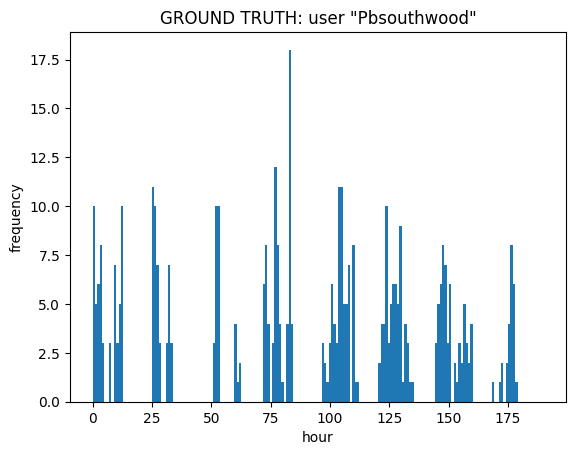

In [ ]:
#=============================================================================
# GROUND TRUTH FOR HOURLY HISTOGRAM [PROVIDED]
#-----------------------------------------------------------------------------

# this generates the ground-truth hourly histogram for a user

firstHour   = int(floor(startTime  / (60*60)))
currentHour = int(floor(lastTime   / (60*60)))

def computeFreqGT(user):
    hour = firstHour + 1
    freq = [0] * (currentHour - firstHour + 1)
    for event in changeStream(changeLog):
        if not event['user'] == user:
            continue
        timeStamp = int(event['timestamp'])
        h = floor(timeStamp / (60 * 60)) - firstHour
        freq[h] += 1
    return(freq)

def plotFreqGT(user):
    freq = computeFreqGT(user)
    hours = list(range(currentHour - firstHour + 1))
    y_pos = np.arange(len(hours))
    #plt.bar(y_pos, freq, align='center', alpha=0.5)
    plt.hist(hours, weights=freq, bins=len(hours))
    #plt.plot(hours, freq)
    plt.xlabel('hour')
    plt.ylabel('frequency')
    plt.title(f'GROUND TRUTH: user "{user}"')
    plt.show()

# e.g.,
freq_gt = plotFreqGT('Pbsouthwood')

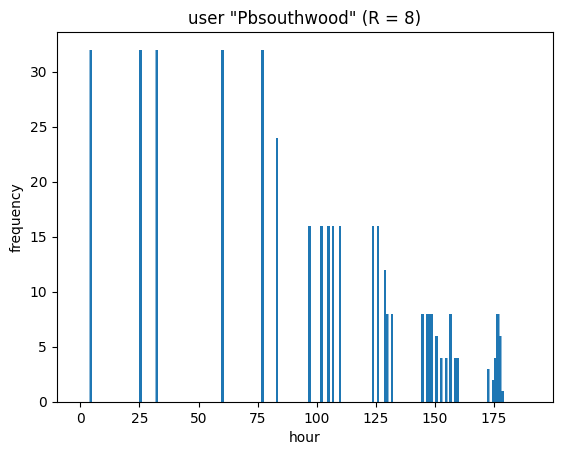

In [ ]:
#=============================================================================
# HOURLY HISTOGRAMS BY SYNOPSIS
#-----------------------------------------------------------------------------

#def plotFreq(user):
# ⋮

# e.g.,
#plotFreq('Pbsouthwood')

### ¶ Absolute Error of the Predicted Histograms

_Compute_ and _plot_ the _absolute error_ of a requested predicted histogram.
Here, we gauge the absolute error of the histogram prediction, to see how accurate the prediction is. The absolute error of the predicted histogram is the absolute difference between the predicted event frequency and the ground truth frequency in each hour for top three users given above. For each user, please compute the error for each hour and draw a line chart. The _absolute error_ for each hour interval is then defined as:
$$|\hat{f}(h) - f(h)|$$
where $\hat{f}(h)$ is the predicted frequency and the $f(h)$ is the ground-truth frequency in hour $h$.

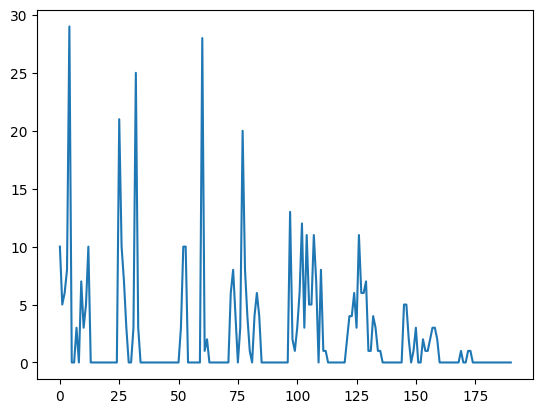

In [ ]:
#=============================================================================
# PLOT ABSOLUTE ERROR OF HISTOGRAM
#-----------------------------------------------------------------------------

#def histErrorPlot(user):
# ⋮

# e.g.,
#histErrorPlot('Pbsouthwood')

### ¶ Relative Error of Synopses

_Compute_ and _plot_ the relative error of a requested synopsis
(that is, for a user)
but built over different **R** values.
Here, we are gauging the relative error of the DGIM synopses,
to verify that the error is capped as we expect.

For this,
we plot the relative error by hour in the stream for a synopsis,
querying from the “end” of the stream.
This requires that we have the _ground truth_.
Let $s(h)$ be the number of events for the given user
from $h$ hours ago from the present (the “end” of the stream),
and $\hat{s}(h)$ be the estimated number of events
by the synopsis.
The _relative error_ is then defined as

$$\frac{|\hat{s}(h) - s(h)|}{s(h)}$$

When $s(h)$ is 0,
return 0 for the relative error.
(Note that really $\hat{s}(h)$ ought to be 0 too in such cases.)

Using the same convention as we did for the _hourly histograms_,
we label the _x axis_ with the hours from left to right
starting with “0” as the start of the stream.

In the same relative-error plot for the given user,
plot the error lines for R = 2, 4, 8, 16, & 32.

You may pass over the “stream” again, if needed, to compute synopses
with respect to each R value.
You need these to make
plots of the relative error of a requested synopsis
as built at the different **R** values.

In [ ]:
#=============================================================================
# GROUND TRUTH OF H TO END (FOR COMPUTING THE RELATIVE ERROR)
#-----------------------------------------------------------------------------

# ⋮


In [ ]:
#=============================================================================
# COMPUTE THE SYNOPSES PER R VALUE
#-----------------------------------------------------------------------------

Rs = [2, 4, 8, 16, 32]

# ⋮


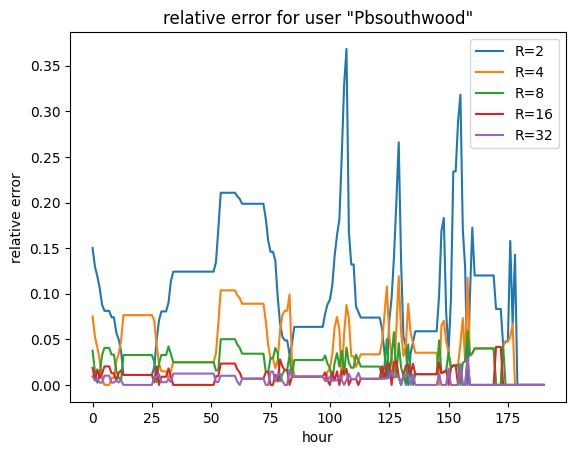

In [ ]:
#=============================================================================
# RELATIVE ERROR PLOT
#-----------------------------------------------------------------------------

#def relativeErrorPlot(user):
# ⋮

# e.g.,
#relativeErrorPlot('Pbsouthwood')

---
## § 3. Report `[10 points]`

|           |                   |
|----------:|:------------------|
|   author: |                   |
| student#: |                   |
|     date: |                   |


---
### ¶ 1. Error of Predicted Histograms `[3 points]`

**Q.** What is your observation of the histogram prediction using DGIM?


**A.**

---
### ¶ 2. Relative Error of Count `[3 points]`

Relative Error of Counting the events in the past k hours

**Q.**
With respect to the DGIM's **R** value,
what is the relationship between the relative error
of the DGIM estimation
of the count of events in the past k hours
versus the ground truth?

**A.**

---
### ¶ 3. Error versus Frequency `[2 points]`

**Q.** Is there a difference in the error of DGIM's estimation over users with different frequencies of contributions?

**A.**

---
### ¶ 4. Bot Detection `[2 points]`

**Q.** How could these techniques maybe be extended to detect whether a user is a _bot_ (an automated program) or is a human?

**A.**